In [ ]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [ ]:
!pip install transformers sentencepiece sacrebleu -q

     |████████████████████████████████| 92 kB 3.8 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
base_model_path = '/gd/MyDrive/models/myv/mbart-large-51-myv-raw'

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [ ]:
old_len = len(tokenizer)
old_len

269545

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
tokenizer.lang_code_to_id['myv_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'myv_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'myv_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('myv_XX')

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/train.v1.json', 'r') as f:
    all_pairs = json.load(f)
print(len(all_pairs))

74503


## Training

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path)

In [ ]:
model.cuda();

### First, update just the new embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [ ]:
tokenizer.src_lang = "myv_XX"
tokenizer.tgt_lang = "ru_RU"

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/9312 [00:00<?, ?it/s]

step 0 loss 9.785296133421
step 500 loss 4.405822748541832
step 1000 loss 1.9253890920877457
error
error
step 1500 loss 1.6297574729919433
step 2000 loss 1.5292696248292923
error
step 2500 loss 1.4626867623925208
error
step 3000 loss 1.370803921341896
step 3500 loss 1.3712821029424667
step 4000 loss 1.321870720744133
error
error
error
step 4500 loss 1.2633198986649514
error
step 5000 loss 1.3033017413020134
error
step 5500 loss 1.2396207549571991
error
step 6000 loss 1.2041881234645844
error
error
step 6500 loss 1.201305781006813
step 7000 loss 1.1852625415623188
step 7500 loss 1.2013110787272454
error
step 8000 loss 1.1347432471513748
step 8500 loss 1.145038591682911
step 9000 loss 1.1417657769322396
error


Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [ ]:
save_model_path = '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1'

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/tokenizer_config.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/special_tokens_map.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/sentencepiece.bpe.model',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/added_tokens.json')

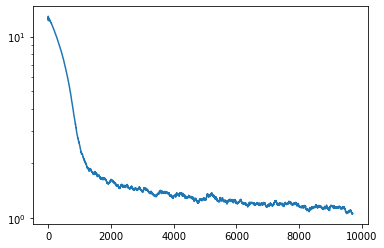

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8
report_steps = 500 
epochs = 3
losses = []

Optimizing all parameters takes x2 longer than just embeddings: about 1h per epoch. 

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/9312 [00:00<?, ?it/s]

step 0 loss 0.9503825902938843
step 500 loss 1.055686499029398
step 1000 loss 1.0169912794232367
step 1500 loss 0.9887424440681934
step 2000 loss 0.9832921919822692
step 2500 loss 0.9614964108169078
step 3000 loss 0.9587579975724221
step 3500 loss 0.9667584648728371
step 4000 loss 0.9176072727143765
step 4500 loss 0.9691766191422939
step 5000 loss 0.9263299844264984
step 5500 loss 0.9157921041846275
step 6000 loss 0.9544448709487915
step 6500 loss 0.9398996981680393
step 7000 loss 0.9314757969975471
step 7500 loss 0.9299839054048061
step 8000 loss 0.8923808116912841
step 8500 loss 0.9060891752615571
step 9000 loss 0.8967325659394264
EPOCH 1


  0%|          | 0/9312 [00:00<?, ?it/s]

step 0 loss 0.9228737407028675
step 500 loss 0.88812294074893
step 1000 loss 0.8759343658983707
step 1500 loss 0.8873065537810325
step 2000 loss 0.8785095971673728
step 2500 loss 0.8644646124243737
step 3000 loss 0.8337153362035752
step 3500 loss 0.8667343288064003
step 4000 loss 0.8820627403855323
step 4500 loss 0.8571549745500088
step 5000 loss 0.8652687788903713
step 5500 loss 0.8597620077729226
step 6000 loss 0.8679697896540165
step 6500 loss 0.8751893592178821
step 7000 loss 0.8687928949296474
step 7500 loss 0.854967110067606
step 8000 loss 0.8607984690070152
step 8500 loss 0.8343796470165252
step 9000 loss 0.8476396285295487
EPOCH 2


  0%|          | 0/9312 [00:00<?, ?it/s]

step 0 loss 0.8607412446737289
step 500 loss 0.8164499323666096
step 1000 loss 0.8267537216544152
step 1500 loss 0.8303699273169041
step 2000 loss 0.8242678221166134
step 2500 loss 0.8216545865386724
step 3000 loss 0.8229495637714863
step 3500 loss 0.806650289952755
step 4000 loss 0.8111292649209499
step 4500 loss 0.8128299108743667
step 5000 loss 0.8278516631126404
step 5500 loss 0.7982070347070694
step 6000 loss 0.8029586943686009
step 6500 loss 0.8138384493589401
step 7000 loss 0.7913681076169014
step 7500 loss 0.8188885310292244
step 8000 loss 0.806558365881443
step 8500 loss 0.7881947735100985
step 9000 loss 0.8368214872479439


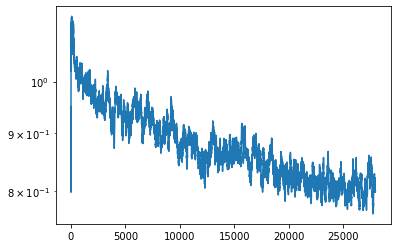

In [ ]:
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/tokenizer_config.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/special_tokens_map.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/sentencepiece.bpe.model',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-ru-v1/added_tokens.json')

In [ ]:
model.eval();

In [ ]:
myv, ru = random.choice(all_pairs)
myv, ru

('5. Нумолотне эсь командаст аравтнесызь истя, штобу виев ды парсте эшксицятне кадовольть удалов.',
 '5. Команды должны расставлять своих игроков так, чтобы меткие и сильно бьющие игроки стояли в конце цепочки.')

In [ ]:
def translate(text, src='myv_XX', trg='ru_RU', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(myv)

'5. Нумолоты делятся на свои команды так, чтобы сильнейшие и лучшие игроки остались позади.'

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

# Evaluate

In [ ]:
!ls /gd/MyDrive/datasets/nlp/myv_corpus/

dev1000.v1.json  myv_mono.v1.json  test1000.v1.json  train.v1.json


In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/dev1000.v1.json', 'r') as f:
    dev = json.load(f)

In [ ]:
dev_target = {k: [ru for er, ru in v] for k, v in dev.items()}

In [ ]:
dev_translated = {k: [translate(er) for er, ru in tqdm(v)] for k, v in dev.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
from sacrebleu import CHRF
chrf_calc = CHRF(word_order=2)

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')

bible                32.95
tales                30.80
constitution         54.25
games                25.08
fiction              22.80
wiki                 48.86


In [ ]:
print(chrf_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

38.823449842762685


In [ ]:
for k in dev:
    print(k)
    for i in range(3):
        print(dev[k][i][0])
        print(dev[k][i][1])
        print(dev_translated[k][i])
        print()

bible
Давид инязороськак корты: «Кадык сынь понгить кундамкас каванямо шкастост! Кадык сынь прыть туворс, ды кадык сы тенст чумонь пандома!
И Давид говорит: да будет трапеза их сетью, тенетами и петлею в возмездие им;
И говорит царь Давид: да отвлекут их во время пиршества, и да прыгают в туву, и да будет им наказание;

Сюкпря Пазонтень, кие кирвазтизе Титэнь седейс тынк кисэ секе жо бажамонть, кона палы минек седейсэяк!
Благодарение Богу, вложившему в сердце Титово такое усердие к вам.
Приветствуйте Бога, возбуждающего за вас желание Тита и наше сердце.

Ансяк бути мон карман одс стявтомо сень, мезенть калавтыя икеле, сестэ теньсэ невтьса: мон – Коень каладыця.
Ибо если я снова созидаю, что разрушил, то сам себя делаю преступником.
Но если бы я был предан тому, что разрушал прежде, то мог бы показать себе, что я продающий закон.

tales
Вана мезе ёвтнить миненек рузонь атятне: зярдо велесь тесэ арасель, се латксонть эрясть розбойникть, эрясть землянкасо.
И вот что рассказывают наши рус

# Translate the monolingual corpus for back-translation

In [ ]:
cleanup()

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.json', 'r') as f:
    all_sentences = json.load(f)
print(len(all_sentences))
random.seed(1)
random.shuffle(all_sentences)

333651


In [ ]:
def translate_batch(texts, src='myv_XX', trg='ru_RU', max_length='auto', num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    if max_length == 'auto':
        max_length = int(10 + encoded.input_ids.shape[1] * 1.5)
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


In [ ]:
translate_batch(all_sentences[:4])

['Приветствую тебя, Хоразин! Приветствую тебя, Бетсаида! Если бы народ Тирский и Сидонский видел чудеса, которые явились вам, то они уже давно одевались в одежду скорби и не сидели бы над кулупами.',
 'Здесь работающих — эти естественные условия, сбор съедобных грибов.',
 'Включает в себя Адамсон Генрих, где открылся Музей чисел Койдула.',
 'Сплыть, девочки!']

In [ ]:
batch_size = 16

In [ ]:
all_translated = []

[]

In [ ]:
cleanup()


for i in trange(0, len(all_sentences), batch_size):
    batch = all_sentences[i: i + batch_size]
    if all_translated[i: i + batch_size]:
        continue
    try:
        all_translated.extend(translate_batch(batch))
    except RuntimeError:
        print('error at', i)
        cleanup()
        bb = []
        for b in batch:
            try:
                bb.append(translate_batch([b])[0])
            except RuntimeError:
                print('mega error!')
                bb.append(b)
                cleanup()
        all_translated.extend(bb)

    if i and (i // batch_size) % 100 == 0:
        with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'w') as f:
            json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)
        print(i, 'saving...')

  0%|          | 0/20854 [00:00<?, ?it/s]

40000 saving...
41600 saving...
43200 saving...
44800 saving...
46400 saving...
48000 saving...
49600 saving...
51200 saving...
52800 saving...
54400 saving...
56000 saving...
57600 saving...
59200 saving...
60800 saving...
62400 saving...
64000 saving...
65600 saving...
67200 saving...
68800 saving...
70400 saving...
72000 saving...
73600 saving...
75200 saving...
76800 saving...
78400 saving...
80000 saving...
81600 saving...
83200 saving...
84800 saving...
86400 saving...
88000 saving...
89600 saving...
91200 saving...
92800 saving...
94400 saving...
96000 saving...
97600 saving...
99200 saving...
100800 saving...
102400 saving...
104000 saving...
105600 saving...
107200 saving...
108800 saving...
110400 saving...
112000 saving...
113600 saving...
115200 saving...
116800 saving...
118400 saving...
120000 saving...
121600 saving...
123200 saving...
124800 saving...
126400 saving...
128000 saving...
129600 saving...
131200 saving...
132800 saving...
134400 saving...
136000 saving...
1

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'w') as f:
    json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)